In [318]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf
import re
from rdflib import URIRef, Literal, Namespace, Graph, XSD
from rdflib.namespace import RDF

In [319]:
g = Graph()
g.parse("data/terraria_upd.owl", format="xml")
triplets = []
for subj, pred, obj in g:
    triplets.append((str(subj), str(pred), str(obj)))


def simplify_uri(uri):
    match = re.search(r"[/#]([^/#]+)$", uri)
    return match.group(1) if match else uri  

triplets = [
    (simplify_uri(subj), simplify_uri(pred), simplify_uri(obj))
    for subj, pred, obj in triplets
]




In [320]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triplets), test_size=0.2)
X_train

array([['солнечный_выброс', 'hasRarity', '10'],
       ['орихалковый_самострел', 'type', 'RangedWeapon'],
       ['артерия', 'hasDamage', '17'],
       ...,
       ['кулак_голема', 'hasDamage', '90'],
       ['адское_пламя', 'hasChanceCritDamage', '4'],
       ['зачарованный_меч', 'hasName', 'Зачарованный меч']], dtype='<U122')

In [321]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [322]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
52/52 [==============================] - 1s 28ms/step - loss: 239.5041
Epoch 2/300
52/52 [==============================] - 1s 10ms/step - loss: 239.4883
Epoch 3/300
52/52 [==============================] - 0s 9ms/step - loss: 239.4725
Epoch 4/300
52/52 [==============================] - 0s 9ms/step - loss: 239.4566
Epoch 5/300
52/52 [==============================] - 1s 10ms/step - loss: 239.4403
Epoch 6/300
52/52 [==============================] - 1s 10ms/step - loss: 239.4235
Epoch 7/300
52/52 [==============================] - 1s 10ms/step - loss: 239.4056
Epoch 8/300
52/52 [==============================] - 1s 10ms/step - loss: 239.3867
Epoch 9/300
52/52 [==============================] - 0s 9ms/step - loss: 239.3666
Epoch 10/300
52/52 [==============================] - 1s 13ms/step - loss: 239.3451
Epoch 11/300
52/52 [==============================] - 1s 10ms/step - loss: 239.3219
Epoch 12/300
52/52 [==============================] - 1s 10ms/step - loss: 239.2967
Epoc

In [323]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

102/102 [==============================] - 2s 20ms/step


In [324]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.35
MR: 91.46
Hits@10: 0.50
Hits@3: 0.38
Hits@1: 0.27


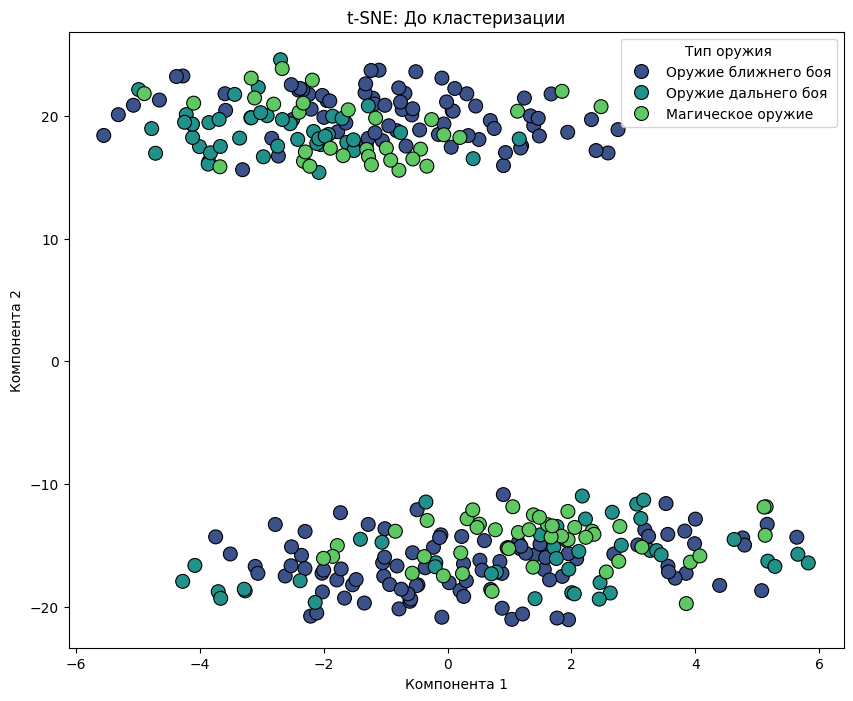

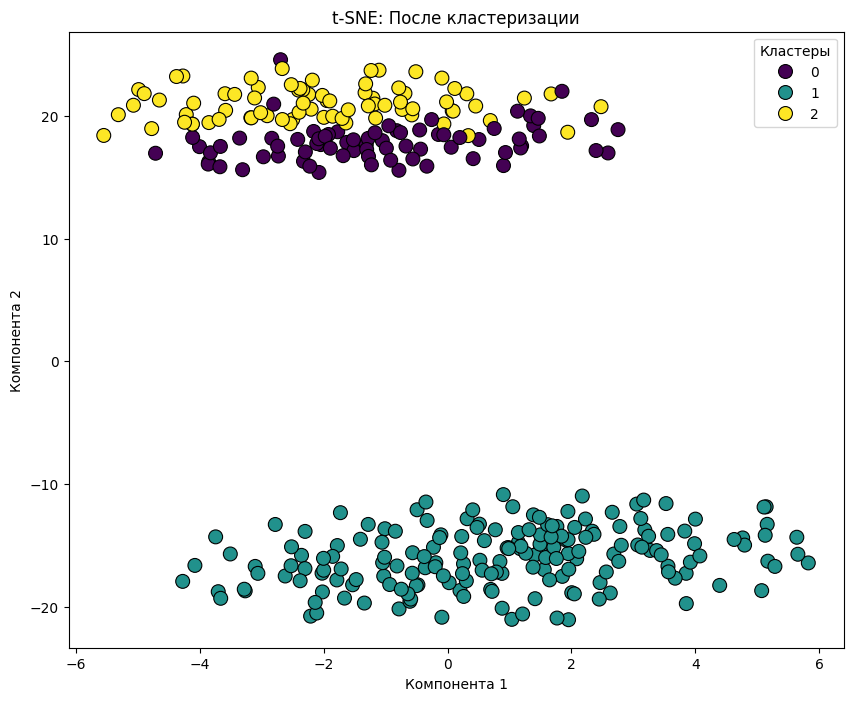

In [325]:
import json
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

with open('data/weapons.json', 'r', encoding='utf-8') as file:
    weapons_data = json.load(file)

df = pd.DataFrame(weapons_data)
df = df.drop(columns=['materials'])

weapon_entities = df['name'].tolist()

try:
    weapons_embeddings = model.get_embeddings(weapon_entities)
except Exception as e:
    print(f"Ошибка генерации эмбеддингов: {e}")
    exit()

weapons_embeddings = np.array(weapons_embeddings)
scaler = StandardScaler()
weapons_embeddings_scaled = scaler.fit_transform(weapons_embeddings)

pca = PCA(n_components=50)
weapons_embeddings_pca = pca.fit_transform(weapons_embeddings_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings_before = tsne.fit_transform(weapons_embeddings_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_embeddings_before[:, 0],
    y=reduced_embeddings_before[:, 1],
    hue=df['weapon_type'],  
    palette='viridis',
    s=100,
    edgecolor='black'
)
plt.title('t-SNE: До кластеризации')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(title='Тип оружия')
plt.show()

# Шаг 7: Кластеризация с использованием KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
predicted_labels = kmeans.fit_predict(weapons_embeddings_pca)

df['cluster'] = predicted_labels

reduced_embeddings_after = tsne.fit_transform(weapons_embeddings_pca)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_embeddings_after[:, 0],
    y=reduced_embeddings_after[:, 1],
    hue=df['cluster'], 
    palette='viridis',
    s=100,
    edgecolor='black'
)
plt.title('t-SNE: После кластеризации')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.legend(title='Кластеры')
plt.show()

true_labels = df['weapon_type'].map({
    'Магическое оружие': 0,
    'Оружие ближнего боя': 1,
    'Оружие дальнего боя': 2
}).values

In [333]:
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Score: {ari_score:.4f}")

Adjusted Rand Score: 0.1708


In [327]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from collections import Counter

y = df['weapon_type'].map({
    'Магическое оружие': 0,
    'Оружие ближнего боя': 1,
    'Оружие дальнего боя': 2
}).values

X = weapons_embeddings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели XGBoost: {accuracy:.4f}")


Точность модели XGBoost: 0.7164


In [328]:
X_train, X_valid = train_test_split_no_unseen(np.array(triplets), test_size=0.2)
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
enemy_subject="зомби"
print(df[df.subject==enemy_subject])

     subject     predicate                                     object
498    зомби     hasHealth                                         45
600    зомби       hasLoot  ['Мозг зомби', 'Ледяной факел', 'Монеты']
824    зомби  hasShopItems                                       мозг
1351   зомби  hasShopItems                                маска_зомби
2152   зомби      hasQuest                                        Нет
2325   зомби     hasRarity                                    Обычное
2431   зомби       hasName                                      Зомби
2960   зомби          type                                        NPC
3725   зомби          type                                      Enemy
3911   зомби  livesInBiome                                поверхность


In [329]:
dfFiltered = np.array(df[(df.subject!=enemy_subject) | ((df.subject==enemy_subject) & ~df.predicate.isin(["hasHealth","livesInBiome"]))])

In [330]:
model.fit(dfFiltered)

Epoch 1/100
6/6 [==============================] - 1s 86ms/step - loss: 74.8195
Epoch 2/100
6/6 [==============================] - 0s 73ms/step - loss: 74.8312
Epoch 3/100
6/6 [==============================] - 0s 76ms/step - loss: 74.8431
Epoch 4/100
6/6 [==============================] - 1s 89ms/step - loss: 74.8561
Epoch 5/100
6/6 [==============================] - 0s 79ms/step - loss: 74.8685
Epoch 6/100
6/6 [==============================] - 0s 75ms/step - loss: 74.8808
Epoch 7/100
6/6 [==============================] - 0s 75ms/step - loss: 74.8914
Epoch 8/100
6/6 [==============================] - 0s 83ms/step - loss: 74.9039
Epoch 9/100
6/6 [==============================] - 0s 77ms/step - loss: 74.9153
Epoch 10/100
6/6 [==============================] - 0s 70ms/step - loss: 74.9265
Epoch 11/100
6/6 [==============================] - 0s 80ms/step - loss: 74.9365
Epoch 12/100
6/6 [==============================] - 0s 83ms/step - loss: 74.9485
Epoch 13/100
6/6 [===================

In [311]:
statements = np.array([
    [f'{enemy_subject}', 'hasHealth', '45'],
    [f'{enemy_subject}', 'hasHealth', '11'],
    [f'{enemy_subject}', 'hasHealth', '2'],
    [f'{enemy_subject}', 'livesInBiome', 'лес'],
    [f'{enemy_subject}', 'livesInBiome', '4'],
    [f'{enemy_subject}', 'livesInBiome', 'поверхность']
])

In [312]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['сигнальная_ракетница', 'hasRarity', '1'],
       ['адамантитовая_глефа', 'hasSpeed', '25'],
       ['рассвет', 'hasDiscard', '5'],
       ...,
       ['оранжевый_запинатор', 'hasSpeed', '36'],
       ['метеоритный_посох', 'hasDamage', '50'],
       ['вонючий_багнак', 'hasRarity', '5']], dtype='<U122')

In [313]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

2/2 [==============================] - 1s 429ms/step


In [314]:
scores = model.predict(statements)
scores

array([11.285311  ,  2.687172  ,  2.3122418 ,  4.7305593 , -0.26907992,
        9.524801  ], dtype=float32)

In [315]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
4,зомби livesInBiome 4,"[1267, 881]",-0.269080,0.433133
2,зомби hasHealth 2,"[45, 180]",2.312242,0.909886
1,зомби hasHealth 11,"[17, 106]",2.687172,0.936265
3,зомби livesInBiome лес,"[7, 3]",4.730559,0.991256
5,зомби livesInBiome поверхность,"[1, 1]",9.524801,0.999927
0,зомби hasHealth 45,"[1, 1]",11.285311,0.999987


In [316]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.38
MR: 209.17
Hits@10: 0.50
Hits@3: 0.42
Hits@1: 0.33
